In [ ]:
pip install --upgrade ultralytics

In [1]:
# Cuts the dataset into 5 folds
import os
import shutil
from sklearn.model_selection import StratifiedKFold
from pathlib import Path

# Parameters: adjust these paths as needed
dataset_dir = r"C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage"
output_dir = r"C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds"
n_splits = 5
random_state = 42
copy_files = True  # Set to False to use symlinks instead of copying

# Gather all samples and class labels
train_dir = Path(dataset_dir) / 'train'
test_dir = Path(dataset_dir) / 'test'
samples = []  # (img_path, lbl_path, class_name)
class_names = []
for cls_dir in sorted(train_dir.iterdir()):
    if not cls_dir.is_dir():
        continue
    cls = cls_dir.name
    class_names.append(cls)
    for img_path in (cls_dir / 'images').glob('*.*'):
        lbl_path = cls_dir / 'labels' / f"{img_path.stem}.txt"
        samples.append((img_path, lbl_path, cls))

# Prepare arrays for stratification
image_paths = [s[0] for s in samples]
label_paths = [s[1] for s in samples]
y = [class_names.index(s[2]) for s in samples]

# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
summary = {}

# Create folds
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(image_paths, y), start=1):
    fold_base = Path(output_dir) / f"fold_{fold_idx}"
    summary[fold_idx] = {'train': len(train_idx), 'val': len(val_idx), 'test': 0}

    # Train/val splits
    for split, idxs in [('train', train_idx), ('val', val_idx)]:
        for cls in class_names:
            (fold_base / split / cls / 'images').mkdir(parents=True, exist_ok=True)
            (fold_base / split / cls / 'labels').mkdir(parents=True, exist_ok=True)
        for i in idxs:
            img_src, lbl_src, cls_name = image_paths[i], label_paths[i], samples[i][2]
            img_dst = fold_base / split / cls_name / 'images' / img_src.name
            lbl_dst = fold_base / split / cls_name / 'labels' / lbl_src.name
            if copy_files:
                shutil.copy(img_src, img_dst)
                shutil.copy(lbl_src, lbl_dst)
            else:
                os.symlink(img_src.resolve(), img_dst)
                os.symlink(lbl_src.resolve(), lbl_dst)

    # Copy test set unchanged
    if test_dir.exists():
        dst_test = fold_base / 'test'
        if dst_test.exists():
            shutil.rmtree(dst_test)
        shutil.copytree(test_dir, dst_test)
        test_images_dir = dst_test / 'images'
        summary[fold_idx]['test'] = len(list(test_images_dir.glob('*.*')))

# Print out summary to verify
print("K-fold generation summary:")
for fold, counts in summary.items():
    print(f"Fold {fold}: train={counts['train']}, val={counts['val']}, test={counts['test']}")


K-fold generation summary:
Fold 1: train=370, val=93, test=0
Fold 2: train=370, val=93, test=0
Fold 3: train=370, val=93, test=0
Fold 4: train=371, val=92, test=0
Fold 5: train=371, val=92, test=0


In [2]:
##TRAINS THE MODEL KFOLD

import os
import gc
import torch
from ultralytics import YOLO

# ---------------- CONFIG ----------------
BASE_DIR    = r"C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds"  # root path where fold_1, …, fold_5 live
MODEL_FILE  = r"models\yolo11n-cls.pt"                         # pretrained classification model
FOLDS       = 5
EPOCHS      = 100
IMGSZ       = 640
BATCH       = 8                                        # reduced for lower VRAM usage
PATIENCE    = 5
DEVICE      = "cuda" if torch.cuda.is_available() else "cpu"
MEM_FRACTION = 0.6                                     # 60% GPU memory cap
# ----------------------------------------

print(f"Using device: {DEVICE}\n")

if DEVICE == "cuda":
    torch.cuda.set_per_process_memory_fraction(MEM_FRACTION, device=0)

for fold in range(1, FOLDS + 1):
    gc.collect()
    torch.cuda.empty_cache()

    fold_dir = os.path.join(BASE_DIR, f"fold_{fold}")
    if not os.path.isdir(os.path.join(fold_dir, 'train')):
        raise FileNotFoundError(f"{fold_dir}/train not found")

    print(f"\n=== Training Fold {fold}/{FOLDS} on folder {fold_dir} ===")
    model = YOLO(MODEL_FILE)
    model.train(
        data=fold_dir,
        task='classify',
        epochs=EPOCHS,
        imgsz=IMGSZ,
        batch=BATCH,
        patience=PATIENCE,
        device=DEVICE,
        project=fold_dir,
        name='results',
        exist_ok=True,
        dropout=0.2,
        weight_decay=0.0005,
        amp=False
    )

    print(f"--- Fold {fold} complete. Best weights in {fold_dir}/results ---")


Using device: cuda


=== Training Fold 1/5 on folder C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_1 ===
Ultralytics 8.3.133  Python-3.9.21 torch-2.5.1+cu121 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_1, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.2, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=models\yolo11n-cls.pt, momentum=0.937, mosa

train: Scanning C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_1\train... 370 images, 0 corrupt: 100%|██████████| 370/370 [00:00<00:00, 651.78it/s]

train: New cache created: C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds\fold_1\train.cache


KeyboardInterrupt: 

In [ ]:
#Checks whhich fold is the best
import pandas as pd
import os
import shutil

# Set the correct base directory where the folds exist
base_dir = r"C:\Users\jazzb\ImageDetection-Yolov11\Road_Damage\folds"

# Dynamically find the fold directories inside the base folder
fold_dirs = [f"fold_{i+1}" for i in range(5)]

results = []

for fold in fold_dirs:
    csv_path = os.path.join(base_dir, fold, "results", "results.csv")
    print(f"Checking: {csv_path} -> Exists: {os.path.exists(csv_path)}")  # Debug line

    if not os.path.exists(csv_path):
        print(f"❌ Missing results.csv in {csv_path}")
        continue

    df = pd.read_csv(csv_path)
    print(f"🔍 Columns in {csv_path}:\n{df.columns.tolist()}")  # Debugging line

    # Look for the accuracy column
    accuracy_column = None
    for col in df.columns:
        if 'accuracy' in col.lower():
            accuracy_column = col
            print(f"✅ Found column: {col}")
            break

    if accuracy_column is None:
        print(f"⚠️ 'accuracy' column not found in {csv_path}")
        continue

    best_row = df.loc[df[accuracy_column].idxmax()]
    train_loss = best_row["train/loss"]
    val_loss = best_row["val/loss"]
    loss_gap = abs(train_loss - val_loss)

    results.append({
        "Fold": fold,
        "Epoch": int(best_row["epoch"]),
        "Accuracy": best_row[accuracy_column],
        "Train Loss": train_loss,
        "Validation Loss": val_loss,
        "Loss Gap": loss_gap,
        "Learning Rate": best_row["lr/pg0"]
    })

results_df = pd.DataFrame(results)

if not results_df.empty:
    print("\n📊 5-Fold Cross-Validation Summary:")
    print(results_df.to_string(index=False))

    # Normalize accuracy and loss gap for ranking
    results_df["Accuracy Rank"] = results_df["Accuracy"].rank(ascending=False)
    results_df["Loss Gap Rank"] = results_df["Loss Gap"].rank(ascending=True)

    # Combined score: prioritize high accuracy + low overfitting
    results_df["Overall Score"] = results_df["Accuracy Rank"] + results_df["Loss Gap Rank"]

    best_fold = results_df.loc[results_df["Overall Score"].idxmin()]
    print(f"\n🎯 Selected Best Generalizing Fold: {best_fold['Fold']} (Epoch {best_fold['Epoch']})")
    print(f"   Accuracy: {best_fold['Accuracy']:.4f}, Loss Gap: {best_fold['Loss Gap']:.4f}")

    # Adjust the model path to match the correct directory structure
    best_model_path = os.path.join(base_dir, best_fold["Fold"], "results", "weights", "best.pt")
    dest_dir = os.path.join(base_dir, "..", "final_model")
    os.makedirs(dest_dir, exist_ok=True)

    if os.path.exists(best_model_path):
        shutil.copy(best_model_path, os.path.join(dest_dir, "best_fold.pt"))
        print(f"📦 Copied best.pt to: {os.path.join(dest_dir, 'best_fold.pt')}")
    else:
        print(f"❌ Missing best.pt at: {best_model_path}")
else:
    print("\n⚠️ No valid results found. Please check the folder structure and CSV files.")

In [ ]:
# CONFUSION MATRIX

from ultralytics import YOLO
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os

# 1. Reload your trained classification weights
weights = "best_fold.pt"

model   = YOLO(weights)

# 2. Grab and extend the model's names dict
names = model.names.copy()
no_damage_idx = max(names.keys()) + 1
names[no_damage_idx] = "no_damage"

# 3. Validation setup
val_root = "Road_Damage/test"
folders  = [
    "potholes",
    "crack_issues",
    "alligator_crack_issues",
    "ravelling",
    "open_manhole"
]

# 4. Invert for lookup
name_to_idx = {v: k for k, v in names.items()}

# 5. Choose a confidence threshold below which we call it "no_damage"
CONF_THRESH = 0.3

y_true, y_pred = [], []

for folder in folders:
    true_idx = name_to_idx[folder]
    img_dir  = os.path.join(val_root, folder, "images")
    for fn in os.listdir(img_dir):
        if not fn.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        path = os.path.join(img_dir, fn)
        y_true.append(true_idx)

        # Run classification
        res = model(path, imgsz=640)[0]

        # Use top1 and top1conf directly
        top_idx  = int(res.probs.top1)
        top_conf = float(res.probs.top1conf)

        # Assign no_damage if confidence is too low
        if top_conf < CONF_THRESH:
            pred_idx = no_damage_idx
        else:
            pred_idx = top_idx

        y_pred.append(pred_idx)
# 6. Print classification report (include labels for all classes)
sorted_idx = sorted(name_to_idx.values())  # e.g. [0,1,2,3,4,5,6]

print("\n📊 Classification Report:")
print(classification_report(
    y_true,
    y_pred,
    labels=sorted_idx,
    target_names=[names[i] for i in sorted_idx],
    zero_division=0
))

# 7. Build & save the confusion matrix
cm = confusion_matrix(
    y_true,
    y_pred,
    labels=sorted_idx
)
disp = ConfusionMatrixDisplay(
    cm,
    display_labels=[names[i] for i in sorted_idx]
)

fig, ax = plt.subplots(figsize=(8, 7))
disp.plot(ax=ax, cmap="Blues", xticks_rotation="vertical")
plt.title("Validation Confusion Matrix (incl. no_damage)")
plt.tight_layout()

out_path = "confusion_matrix_with_no_damage.png"
plt.savefig(out_path, dpi=150)
print(f"Saved confusion matrix to {out_path}")
plt.close(fig)



0: 640x640 crack_issues 1.00, alligator_crack_issues 0.00, open_manhole 0.00, potholes 0.00, ravelling 0.00, 25.2ms
Speed: 10.0ms preprocess, 25.2ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 crack_issues 0.96, alligator_crack_issues 0.04, open_manhole 0.00, potholes 0.00, ravelling 0.00, 24.5ms
Speed: 9.3ms preprocess, 24.5ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 alligator_crack_issues 0.94, crack_issues 0.02, open_manhole 0.02, potholes 0.02, ravelling 0.00, 25.3ms
Speed: 9.0ms preprocess, 25.3ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 potholes 0.71, crack_issues 0.25, open_manhole 0.03, alligator_crack_issues 0.02, ravelling 0.00, 24.3ms
Speed: 9.2ms preprocess, 24.3ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 crack_issues 1.00, alligator_crack_issues 0.00, open_manhole 0.00, potholes 0.00, ravelling 0.00, 23.6ms
Speed: 9.5ms preprocess, 2

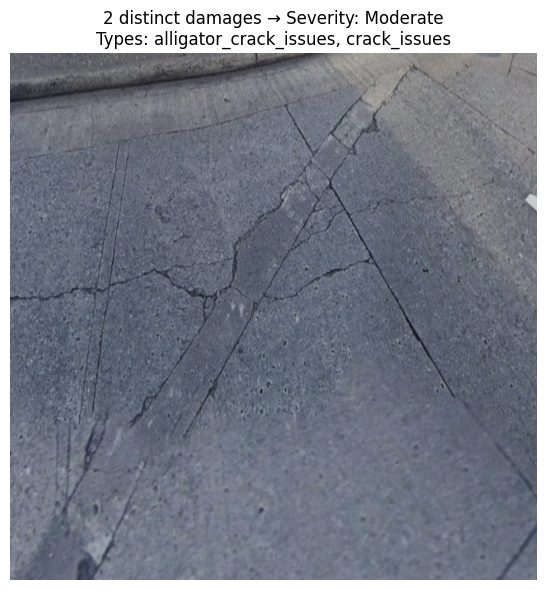

In [8]:
##Checks how many road damages are in the image using window
import cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt

# 1. Load model
model = YOLO("best_fold.pt")
model.eval()

# 2. Parameters
image_path  = "Road_Damage/test/crack_issues/images/12- Cracks9 (1).jpg"
patch_size  = 256
stride      = 128
conf_thresh = 0.7

# 3. Read image
img_bgr = cv2.imread(image_path)
img     = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
h, w, _  = img.shape

# 4. Slide window & collect **all** positive detections
all_detections = []
for y in range(0, h - patch_size + 1, stride):
    for x in range(0, w - patch_size + 1, stride):
        patch = img[y:y+patch_size, x:x+patch_size]
        res   = model(patch, imgsz=patch_size)[0]
        conf  = float(res.probs.top1conf)
        cls   = int(res.probs.top1)
        if conf >= conf_thresh:
            label = model.names.get(cls, str(cls))
            all_detections.append({
                "label": label,
                "conf":  conf,
                "coords": (x, y)
            })


# --- DEBUG: Print Top 8 Patches by Confidence ---
all_detections.sort(key=lambda d: d["conf"], reverse=True)
top_dets = all_detections[:8]   # only top 8 patches

# --- DEBUG: Print Top 8 Patches by Confidence ---
print("=== Top 8 patch detections ===")
for i, det in enumerate(top_dets, 1):
    x, y = det["coords"]
    print(f"{i}. Class: {det['label']:<15} Confidence: {det['conf']:.3f}  at x={x}, y={y}")
print("==============================\n")


# 5. Now build the *unique* label set for severity logic
unique_labels = {d["label"] for d in top_dets}

# 7. Determine severity
n = len(unique_labels)
if   n == 0: severity = "None"
elif n == 1: severity = "Low"
elif n == 2: severity = "Moderate"
else:        severity = "High"


# 7. Print summary & list of found types
print(f"The image has {n} distinct damage{'s' if n!=1 else ''} found, this road is determined to have {severity} severity")
if n > 0:
    print("Detected damage types:", ", ".join(sorted(unique_labels)))
else:
    print("No damage types detected above threshold")

# 8. Display full image with title
title_lines = [
    f"{n} distinct damage{'s' if n!=1 else ''} → Severity: {severity}"
]
if n > 0:
    title_lines.append("Types: " + ", ".join(sorted(unique_labels)))

plt.figure(figsize=(8,6))
plt.imshow(img)
plt.axis("off")
plt.title("\n".join(title_lines), fontsize=12)
plt.tight_layout()
plt.show()
